In [53]:
import pandas as pd
import numpy as np
import imblearn
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [5]:
#balancing the dataset here:
df = pd.read_csv('diabetes.csv')
undersample = NearMiss(version=1)
X = df.loc[:, df.columns != 'Diabetes_binary']
y = df.loc[:, df.columns == 'Diabetes_binary']
X, y = undersample.fit_resample(X, y)

#splitting the balanced dataset into train and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#putting the balanced datasets into individual dataframes for the train and test splits
df_undersampled_train = pd.DataFrame(X_train_scaled, columns = X.columns)
df_undersampled_train['Diabetes_binary'] = y_train
df_undersampled_train.head()

df_undersampled_test = pd.DataFrame(X_test_scaled, columns = X.columns)
df_undersampled_test['Diabetes_binary'] = y_test
df_undersampled_test.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,-1.212894,0.876922,0.074482,-1.061978,1.158253,-0.225623,-0.384172,0.514775,-1.494245,0.418265,...,-0.237966,1.255723,-0.332699,-0.446002,-0.485309,-1.036097,0.367769,-1.162526,-0.619867,NaN
1,-1.212894,-1.140353,0.074482,0.377975,1.158253,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,-0.639948,-0.332699,-0.446002,-0.485309,0.965161,-2.279439,0.864409,0.843982,NaN
2,0.824475,0.876922,0.074482,1.017954,-0.863369,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,0.307887,-0.332699,-0.220989,-0.485309,0.965161,-0.073432,0.864409,0.843982,NaN
3,-1.212894,0.876922,0.074482,0.377975,-0.863369,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,-0.639948,-0.332699,-0.446002,-0.485309,-1.036097,-0.514634,0.864409,0.356032,NaN
4,0.824475,-1.140353,0.074482,2.777896,-0.863369,-0.225623,-0.384172,0.514775,0.669234,0.418265,...,-0.237966,1.255723,4.162593,0.679064,2.060543,0.965161,-1.397036,0.864409,-1.595766,0.0


# Features Choosing From LassoCV Selection Technique

In [51]:
#Creating the dataframe that will contain the features that I selected through LassoCV technique
X_selected_train = df_undersampled_train.loc[:, ['HighBP', 'BMI', 'Smoker','HeartDiseaseorAttack', 'HvyAlcoholConsump',
                                                 'GenHlth','MentHlth', 'PhysHlth', 'DiffWalk']]

X_selected_test = df_undersampled_test.loc[:, ['HighBP', 'BMI', 'Smoker','HeartDiseaseorAttack', 'HvyAlcoholConsump',
                                               'GenHlth','MentHlth', 'PhysHlth', 'DiffWalk']]

# Feature Selection From SFS Method

In [37]:
sfs_selected_train = df_undersampled_train.iloc[:, [3, 5, 6, 7, 9, 13, 14, 15, 20]]
sfs_selected_test = df_undersampled_test.iloc[:, [3,  5,  6, 7, 9, 13, 14, 15, 20]]

# XGBoost Model Creation and Parameter Tuning

In [38]:
xgb_gs = GridSearchCV(estimator = XGBClassifier(),
                     param_grid={'objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
                                'learning_rate':[0.3, 0.6, 0.9],
                                'max_depth': [6, 12, 18],
                                'min_child_weight': [1, 5, 10],
                                'subsamples': [0.5, 0.75, 1],
                                'colsample_bytree': [0.5, 0.7, 1],
                                'seed':[42]},
                     cv = 5,
                     verbose = 3,
                     n_jobs = -1)
xgb_gs.fit(X_selected_train, y_train.values.ravel())

print(xgb_gs.best_params_)
print(xgb_gs.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 42, 'subsamples': 0.5}
0.8569840047721933


C:\Users\Felipe\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [16:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)


## XGBoost Model Performance

Important to note what is a XGBoost model

    * It is an implementation of gradient boosting decision trees
    * Creates a series of models and combines them to make an overall model that is more accurate
    
    
Why to use XGBOost

    * It is a robust machine learning model
    * Easy to use
    * Fast on large datasets
    * There isnt much of a need for optimization but still encouraged
    * OFfers built in regularization
    * Handles sparse data sets using weighted quantile sketch algorithm
        * Meaning that it deals with non-zero entries and maintains its computational complexity like stochastic gradient descent
    * Easy to scale up on multicore machines or clusters
    * uses disk based data structures instead of in-memory ones during computation

C:\Users\Felipe\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [02:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy: 0.8570447013175976
Classification Report for Train: 
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     24745
         1.0       0.93      0.77      0.84     24739

    accuracy                           0.86     49484
   macro avg       0.87      0.86      0.86     49484
weighted avg       0.87      0.86      0.86     49484


Confusion Matrix:
[[23271  1474]
 [ 5600 19139]]

Test Accuracy: 0.8518955111278763
Classification Report for Test: 
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86     10601
         1.0       0.92      0.77      0.84     10607

    accuracy                           0.85     21208
   macro avg       0.86      0.85      0.85     21208
weighted avg       0.86      0.85      0.85     21208


Confusion Matrix:
[[9926  675]
 [2466 8141]]



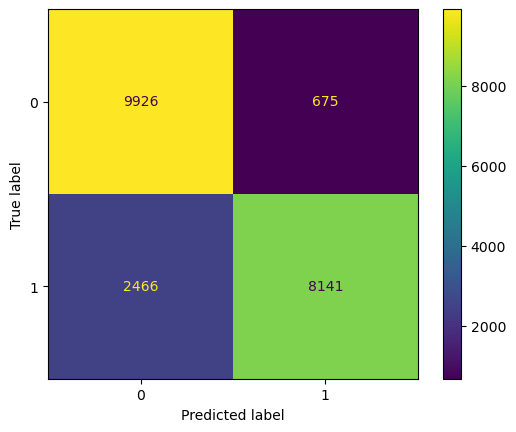

In [54]:
xgb = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth=6, min_child_weight=1,
                    objective='binary:hinge', seed=1, subsamples=0.5)
xgb.fit(X_selected_train, y_train.values.ravel())

xbg_train_pred = xgb.predict(X_selected_train)
xbg_train_score = accuracy_score(y_train.values.ravel(), xbg_train_pred)

xbg_test_pred = xgb.predict(X_selected_test)
xbg_test_score = accuracy_score(y_test.values.ravel(), xbg_test_pred)

print(f'Train Accuracy: {xbg_train_score}')
print(f'Classification Report for Train: \n{classification_report(y_train.values.ravel(), xbg_train_pred)}\n')
print(f'Confusion Matrix:\n{confusion_matrix(y_train.values.ravel(), xbg_train_pred)}\n')

print(f'Test Accuracy: {xbg_test_score}')
print(f'Classification Report for Test: \n{classification_report(y_test.values.ravel(), xbg_test_pred)}\n')
print(f'Confusion Matrix:\n{confusion_matrix(y_test.values.ravel(), xbg_test_pred)}\n')

disp = ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), xbg_test_pred), display_labels=xgb.classes_)
disp.plot()
plt.show()

C:\Users\Felipe\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [02:02:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy: 0.8809514186403686
Classification Report for Train: 
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     24745
         1.0       0.94      0.82      0.87     24739

    accuracy                           0.88     49484
   macro avg       0.89      0.88      0.88     49484
weighted avg       0.89      0.88      0.88     49484


Confusion Matrix:
[[23412  1333]
 [ 4558 20181]]

Test Accuracy: 0.8741512636740852
Classification Report for Test: 
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88     10601
         1.0       0.93      0.81      0.87     10607

    accuracy                           0.87     21208
   macro avg       0.88      0.87      0.87     21208
weighted avg       0.88      0.87      0.87     21208


Confusion Matrix:
[[9953  648]
 [2021 8586]]



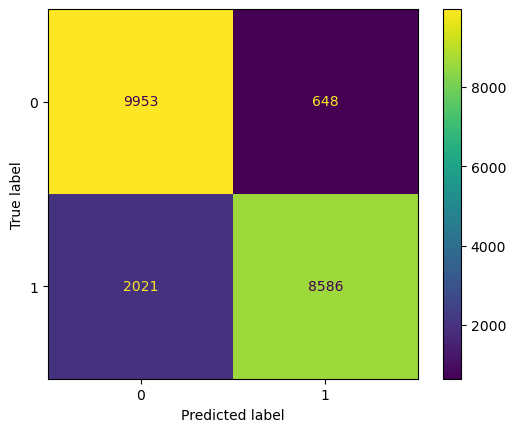

In [55]:
xgb = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth=6, min_child_weight=1,
                    objective='binary:hinge', seed=1, subsamples=0.5)
xgb.fit(sfs_selected_train, y_train.values.ravel())

xbg_train_pred = xgb.predict(sfs_selected_train)
xbg_train_score = accuracy_score(y_train.values.ravel(), xbg_train_pred)

xbg_test_pred = xgb.predict(sfs_selected_test)
xbg_test_score = accuracy_score(y_test.values.ravel(), xbg_test_pred)

print(f'Train Accuracy: {xbg_train_score}')
print(f'Classification Report for Train: \n{classification_report(y_train.values.ravel(), xbg_train_pred)}\n')
print(f'Confusion Matrix:\n{confusion_matrix(y_train.values.ravel(), xbg_train_pred)}\n')

print(f'Test Accuracy: {xbg_test_score}')
print(f'Classification Report for Test: \n{classification_report(y_test.values.ravel(), xbg_test_pred)}\n')
print(f'Confusion Matrix:\n{confusion_matrix(y_test.values.ravel(), xbg_test_pred)}\n')

disp = ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), xbg_test_pred), display_labels=xgb.classes_)
disp.plot()
plt.show()

# Extreme Machine Learning Model

* While it is a feed forward neural network it has a few differences
    * First, is that it does not use back propogation
    * Second, the weights for the hidden layers are randomly generated
    * Lastly,  the output is linear rather than sigmoidal

In [41]:
input_length = X_selected_train.shape[1]
hidden_units = 1000

win = np.random.normal(size = [input_length, hidden_units])

def input_to_hidden(x):
    a = np.dot(x, win)
    a = np.maximum(a, 0, a)
    return a

x_h_v = input_to_hidden(X_selected_train)
x_h_t = np.transpose(x_h_v)
w_out = np.dot(np.linalg.inv(np.dot(x_h_t, x_h_v)), np.dot(x_h_t, y_train))

def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, w_out)
    return y

extreme_pred = predict(X_selected_test)
num_correct = 0
total = extreme_pred.shape[0]
for i in range(total):
    predicted = np.argmax(extreme_pred[i])
    test = np.argmax(y_test.values.ravel()[i])
    num_correct = num_correct + (1 if predicted == test else 0)
    
print('Accuracy of test set: {:f}'.format(num_correct/total))

extreme_pred = predict(X_selected_train)
num_correct = 0
total = extreme_pred.shape[0]
for i in range(total):
    predicted = np.argmax(extreme_pred[i])
    train = np.argmax(y_train.values.ravel()[i])
    num_correct = num_correct + (1 if predicted == train else 0)
    
print('Accuracy of train set: {:f}'.format(num_correct/total))

Accuracy of test set: 1.000000
Accuracy of train set: 1.000000


In [42]:
input_length = sfs_selected_train.shape[1]
hidden_units = 1000

win = np.random.normal(size = [input_length, hidden_units])

def input_to_hidden(x):
    a = np.dot(x, win)
    a = np.maximum(a, 0, a)
    return a

x_h_v = input_to_hidden(sfs_selected_train)
x_h_t = np.transpose(x_h_v)
w_out = np.dot(np.linalg.inv(np.dot(x_h_t, x_h_v)), np.dot(x_h_t, y_train))

def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, w_out)
    return y

extreme_pred = predict(sfs_selected_test)
num_correct = 0
total = extreme_pred.shape[0]
for i in range(total):
    predicted = np.argmax(extreme_pred[i])
    test = np.argmax(y_test.values.ravel()[i])
    num_correct = num_correct + (1 if predicted == test else 0)
    
print('Accuracy of test set: {:f}'.format(num_correct/total))

extreme_pred = predict(sfs_selected_train)
num_correct = 0
total = extreme_pred.shape[0]
for i in range(total):
    predicted = np.argmax(extreme_pred[i])
    train = np.argmax(y_train.values.ravel()[i])
    num_correct = num_correct + (1 if predicted == train else 0)
    
print('Accuracy of train set: {:f}'.format(num_correct/total))

Accuracy of test set: 1.000000
Accuracy of train set: 1.000000


# Basic Deep Learning Model

* Basic feed forward neural network
    * This neural network has 2 hidden layers, 1 input and 1 output layer
    

In [72]:
nn = Sequential()
nn.add(Dense(20, input_shape=(9,), activation='relu'))
nn.add(Dense(40, activation='relu'))
nn.add(Dense(10, activation = 'relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(loss = 'binary_crossentropy', optimizer='adam', metrics='accuracy')
nn.fit(X_selected_train, y_train.values.ravel(), epochs=50, batch_size=10)

_, train_accuracy = nn.evaluate(X_selected_train, y_train)
_2, test_accuracy = nn.evaluate(X_selected_test, y_test)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
4949/4949 [==============================] - 4s 722us/step - loss: 0.3511 - accuracy: 0.8416
Epoch 2/50
4949/4949 [==============================] - 4s 734us/step - loss: 0.3299 - accuracy: 0.8520
Epoch 3/50
4949/4949 [==============================] - 4s 763us/step - loss: 0.3263 - accuracy: 0.8543
Epoch 4/50
4949/4949 [==============================] - 4s 757us/step - loss: 0.3235 - accuracy: 0.8544
Epoch 5/50
4949/4949 [==============================] - 4s 769us/step - loss: 0.3231 - accuracy: 0.8538
Epoch 6/50
4949/4949 [==============================] - 4s 734us/step - loss: 0.3225 - accuracy: 0.8542
Epoch 7/50
4949/4949 [==============================] - 4s 734us/step - loss: 0.3216 - accuracy: 0.8554
Epoch 8/50
4949/4949 [==============================] - 4s 736us/step - loss: 0.3209 - accuracy: 0.8557
Epoch 9/50
4949/4949 [==============================] - 4s 733us/step - loss: 0.3204 - accuracy: 0.8564
Epoch 10/50
4949/4949 [==============================] - 4s 726u

663/663 [==============================] - 0s 621us/step


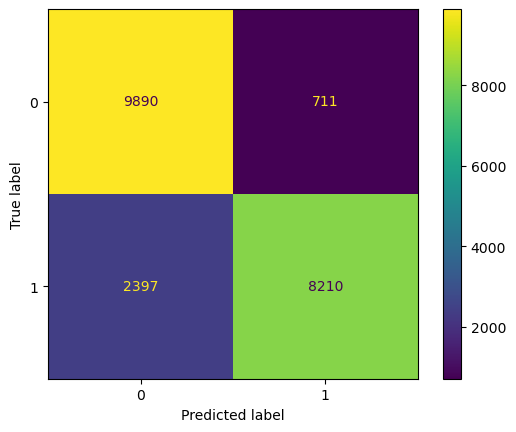

Test Accuracy: 0.8534515500068665
Classification Report for Test: 
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86     10601
         1.0       0.92      0.77      0.84     10607

    accuracy                           0.85     21208
   macro avg       0.86      0.85      0.85     21208
weighted avg       0.86      0.85      0.85     21208




In [73]:
nn_test_pred = nn.predict(X_selected_test)
nn_test_pred = np.round(nn_test_pred)

cm = confusion_matrix(y_test, nn_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), nn_test_pred), display_labels = xgb.classes_)
disp.plot()
plt.show()

print(f'Test Accuracy: {test_accuracy}')
print(f'Classification Report for Test: \n{classification_report(y_test.values.ravel(), nn_test_pred)}\n')

In [68]:
nn = Sequential()
nn.add(Dense(20, input_shape=(9,), activation='relu'))
nn.add(Dense(40, activation='relu'))
nn.add(Dense(10, activation = 'relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(loss = 'binary_crossentropy', optimizer='adam', metrics='accuracy')
nn.fit(sfs_selected_train, y_train.values.ravel(), epochs=50, batch_size=10)

_, train_accuracy = nn.evaluate(sfs_selected_train, y_train)
_2, test_accuracy = nn.evaluate(sfs_selected_test, y_test)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
4949/4949 [==============================] - 4s 729us/step - loss: 0.3124 - accuracy: 0.8634
Epoch 2/50
4949/4949 [==============================] - 4s 728us/step - loss: 0.2928 - accuracy: 0.8752
Epoch 3/50
4949/4949 [==============================] - 4s 730us/step - loss: 0.2896 - accuracy: 0.8757
Epoch 4/50
4949/4949 [==============================] - 4s 743us/step - loss: 0.2883 - accuracy: 0.8760
Epoch 5/50
4949/4949 [==============================] - 4s 735us/step - loss: 0.2871 - accuracy: 0.8759
Epoch 6/50
4949/4949 [==============================] - 4s 745us/step - loss: 0.2861 - accuracy: 0.8761
Epoch 7/50
4949/4949 [==============================] - 4s 748us/step - loss: 0.2857 - accuracy: 0.8776
Epoch 8/50
4949/4949 [==============================] - 4s 738us/step - loss: 0.2850 - accuracy: 0.8778
Epoch 9/50
4949/4949 [==============================] - 4s 724us/step - loss: 0.2850 - accuracy: 0.8775
Epoch 10/50
4949/4949 [==============================] - 4s 725u

663/663 [==============================] - 0s 544us/step


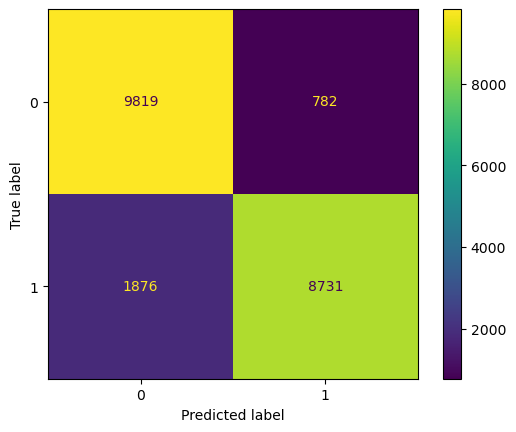

Test Accuracy: 0.8746699094772339
Classification Report for Test: 
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88     10601
         1.0       0.92      0.82      0.87     10607

    accuracy                           0.87     21208
   macro avg       0.88      0.87      0.87     21208
weighted avg       0.88      0.87      0.87     21208




In [70]:
nn_test_pred = nn.predict(sfs_selected_test)
nn_test_pred = np.round(nn_test_pred)

cm = confusion_matrix(y_test, nn_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), nn_test_pred), display_labels = xgb.classes_)
disp.plot()
plt.show()

print(f'Test Accuracy: {test_accuracy}')
print(f'Classification Report for Test: \n{classification_report(y_test.values.ravel(), nn_test_pred)}\n')

# Ensemble Model

    * This model combines a n number of models into one and decides final prediction through various methods
    * This model uses the voting method
        * With hard voting so the predictions are based on majority vote

Train Accuracy: 0.8555290598981489
Classification Report for Train: 
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     24745
         1.0       0.92      0.78      0.84     24739

    accuracy                           0.86     49484
   macro avg       0.86      0.86      0.85     49484
weighted avg       0.86      0.86      0.85     49484


Test Accuracy: 0.8515654470011317
Classification Report for Test: 
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.86     10601
         1.0       0.91      0.78      0.84     10607

    accuracy                           0.85     21208
   macro avg       0.86      0.85      0.85     21208
weighted avg       0.86      0.85      0.85     21208




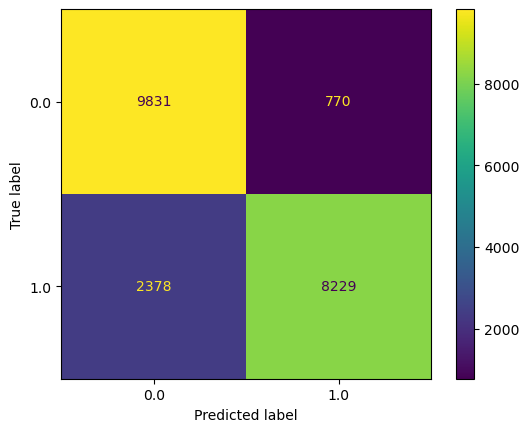

In [66]:
model_1 = RandomForestClassifier(criterion = 'entropy',max_features = 'sqrt', max_depth = 15, min_samples_split = 2,min_samples_leaf=17, random_state=42)
model_2 = SVC(C = 5, degree = 3, gamma = 'auto', kernel = 'rbf')
model_3 = LogisticRegression(C = 8, l1_ratio = 0, penalty = 'l1', random_state=42, solver = 'saga')

ensemble_model = VotingClassifier(estimators = [('rf', model_1), ('svm', model_2), ('lg', model_3)],
                                 voting = 'hard',
                                 n_jobs = -1,
                                 verbose = True)
ensemble_model.fit(X_selected_train, y_train.values.ravel())
ensemble_pred_train = ensemble_model.predict(X_selected_train)
ensemble_pred_test = ensemble_model.predict(X_selected_test)

ensemble_train_score = accuracy_score(y_train.values.ravel(), ensemble_pred_train)
ensemble_test_score = accuracy_score(y_test.values.ravel(), ensemble_pred_test)

print(f'Train Accuracy: {ensemble_train_score}')
print(f'Classification Report for Train: \n{classification_report(y_train.values.ravel(), ensemble_pred_train)}\n')

print(f'Test Accuracy: {ensemble_test_score}')
print(f'Classification Report for Test: \n{classification_report(y_test.values.ravel(), ensemble_pred_test)}\n')

disp = ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), ensemble_pred_test), display_labels=ensemble_model.classes_)
disp.plot()
plt.show()

Train Accuracy: 0.8776574246221001
Classification Report for Train: 
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88     24745
         1.0       0.93      0.82      0.87     24739

    accuracy                           0.88     49484
   macro avg       0.88      0.88      0.88     49484
weighted avg       0.88      0.88      0.88     49484


Test Accuracy: 0.872736703130894
Classification Report for Test: 
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88     10601
         1.0       0.92      0.82      0.87     10607

    accuracy                           0.87     21208
   macro avg       0.88      0.87      0.87     21208
weighted avg       0.88      0.87      0.87     21208




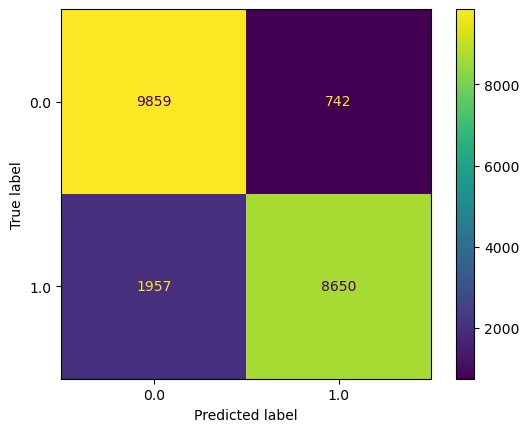

In [67]:
model_1 = RandomForestClassifier(criterion = 'entropy',max_features = 'sqrt', max_depth = 15, min_samples_split = 2,min_samples_leaf=17, random_state=42)
model_2 = SVC(C = 5, degree = 3, gamma = 'auto', kernel = 'rbf')
model_3 = LogisticRegression(C = 8, l1_ratio = 0, penalty = 'l1', random_state=42, solver = 'saga')

ensemble_model = VotingClassifier(estimators = [('rf', model_1), ('svm', model_2), ('lg', model_3)],
                                 voting = 'hard',
                                 n_jobs = -1,
                                 verbose = True)
ensemble_model.fit(sfs_selected_train, y_train.values.ravel())
ensemble_pred_train = ensemble_model.predict(sfs_selected_train)
ensemble_pred_test = ensemble_model.predict(sfs_selected_test)

ensemble_train_score = accuracy_score(y_train.values.ravel(), ensemble_pred_train)
ensemble_test_score = accuracy_score(y_test.values.ravel(), ensemble_pred_test)

print(f'Train Accuracy: {ensemble_train_score}')
print(f'Classification Report for Train: \n{classification_report(y_train.values.ravel(), ensemble_pred_train)}\n')

print(f'Test Accuracy: {ensemble_test_score}')
print(f'Classification Report for Test: \n{classification_report(y_test.values.ravel(), ensemble_pred_test)}\n')

disp = ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(), ensemble_pred_test), display_labels=ensemble_model.classes_)
disp.plot()
plt.show()

# Once Again The Wrapper Method Seems To Offer The Best Results